In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os
import math
from math import log10, sqrt 

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

numpy version : 1.19.5
tensorflow version : 2.4.1


In [2]:
K.clear_session()

In [3]:
n_selected_frames = 300

sub_frames = []
Image_Width = 512
Image_Height = 512


cap = cv2.VideoCapture("../input/video-for-parasin/video.mp4")

counter = 1
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if frame is None:
        break
    if counter > n_selected_frames:
      break
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    rgb_frame = cv2.resize(rgb_frame, (Image_Width, Image_Height), interpolation = cv2.INTER_AREA)
    frames.append(rgb_frame)

    counter += 1
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #  break
frames = np.stack(frames, axis=0)

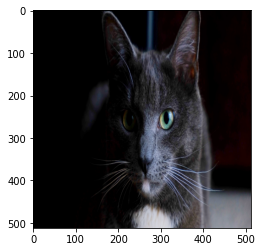

In [4]:
plt.imshow(frames[150])

In [6]:
print("Number of Frames : ", len(frames))
print("Frames shape : ", frames[0].shape)

Number of Frames :  300
Frames shape :  (512, 512, 3)


In [7]:
for counter in range(0, len(frames), 1):
    #resized = cv2.resize(frames[counter], (Image_Width, Image_Height), interpolation = cv2.INTER_AREA)
    #sub_frames.append(resized / 255.)
    sub_frames.append(frames[counter] / 255.)

In [8]:
def make_coordiante(shape):
    x_coordinates = np.linspace(-1, +1, shape[0])
    y_coordinates = np.linspace(-1, +1, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [9]:
Coordinates = make_coordiante((Image_Width, Image_Height))

In [10]:
Coordinates.shape

(262144, 2)

In [11]:
def make_timecode(n_frame, Coordinates):
    t_coordinates = np.linspace(-1, +1, n_frame)
    t_coordinates = np.tile(t_coordinates, [Image_Width * Image_Height,1]).T.reshape((-1,1))
    Coordinates = np.tile(Coordinates, [n_frame, 1])
    #TS_Coordinates = np.concatenate([t_coordinates, Coordinates], axis=1)
    #return TS_Coordinates
    return t_coordinates, Coordinates

In [12]:
T_Coordinates, S_Coordinates = make_timecode(n_selected_frames, Coordinates)

In [13]:
RGB_values = []
#len(sub_frames)
for counter in range(n_selected_frames):
    buff = np.array([sub_frames[counter][:,:,color].flatten() for color in range(3)]).T
    RGB_values.append(buff)

RGB_values = np.concatenate(RGB_values, axis=0)

In [14]:
RGB_values.shape

(78643200, 3)

In [15]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

In [16]:
K.clear_session()

In [17]:
hidden_units = 1024

input_initializers = tf.keras.initializers.RandomUniform(minval=-1/2, maxval=1/2)
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/30, maxval=np.sqrt(6/hidden_units)/30)

In [18]:
#X = tf.keras.layers.Input(shape=(2 * n_fourier_features,))
X = tf.keras.layers.Input(shape=(2,))
T = tf.keras.layers.Input(shape=(1,))


#t1 = tf.keras.layers.Dense(2)(T)
t1 = ParaSineLayer(1, 2, is_first=True)(T)

#t2 = tf.keras.layers.Dense(hidden_units)(T)
t2 = ParaSineLayer(1, hidden_units, is_first=True)(T)

#t3 = tf.keras.layers.Dense(hidden_units)(T)
t3 = ParaSineLayer(1, hidden_units, is_first=True)(T)

#t4 = tf.keras.layers.Dense(hidden_units)(T)
t4 = ParaSineLayer(1, hidden_units, is_first=True)(T)

#t5 = tf.keras.layers.Dense(hidden_units)(T)
#t5 = ParaSineLayer(1, hidden_units, is_first=True)(T)

XT = tf.keras.layers.Add()([X, t1])
#XT = tf.keras.layers.Multiply()([X, t1])
x = ParaSineLayer(2, hidden_units, is_first=True)(XT)

x = tf.keras.layers.Add()([x, t2])
#x = tf.keras.layers.Multiply()([x, t2])
x = ParaSineLayer(hidden_units, hidden_units)(x)

x = tf.keras.layers.Add()([x, t3])
#x = tf.keras.layers.Multiply()([x, t3])
x = ParaSineLayer(hidden_units, hidden_units)(x)

x = tf.keras.layers.Add()([x, t4])
#x = tf.keras.layers.Multiply()([x, t4])
x = ParaSineLayer(hidden_units, hidden_units)(x)

#x = tf.keras.layers.Add()([x, t5])
#x = ParaSineLayer(hidden_units, hidden_units)(x)

Y = tf.keras.layers.Dense(3, kernel_initializer=hidden_initializers)(x)
#Y = ParaSineLayer(hidden_units, 3)(x)

model = tf.keras.models.Model([X, T], Y)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
para_sine_layer (ParaSineLayer) (None, 2)            11          input_2[0][0]                    
__________________________________________________________________________________________________
add (Add)                       (None, 2)            0           input_1[0][0]                    
                                                                 para_sine_layer[0][0]        

In [20]:
#from sklearn.utils import shuffle

#S_Coordinates, T_Coordinates, RGB_values = shuffle(S_Coordinates, T_Coordinates, RGB_values)
#dataset = tf.data.Dataset.from_tensor_slices(((S_Coordinates, T_Coordinates), RGB_values))
#dataset = dataset.batch(20000)

#S_Coordinates, RGB_values = shuffle(TS_Coordinates, RGB_values)
#dataset = tf.data.Dataset.from_tensor_slices((TS_Coordinates, RGB_values))

In [21]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch % 5 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [22]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError()

In [23]:
model.compile(optimizer=optimizer, loss=loss)

In [24]:
#history = model.fit(dataset, epochs=20, callbacks=[callback])
history = model.fit(x=(S_Coordinates, T_Coordinates), y=RGB_values, batch_size=30000, epochs=20, callbacks=[callback])

Epoch 1/20
2622/2622 [==============================] - 533s 201ms/step - loss: 0.0067
Epoch 2/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0030
Epoch 3/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0025
Epoch 4/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0022
Epoch 5/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0020
Epoch 6/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0019
Epoch 7/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0018s - 
Epoch 8/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0017
Epoch 9/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0016
Epoch 10/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0015
Epoch 11/20
2622/2622 [==============================] - 525s 200ms/step - loss: 0.0015
Epoch 12/20
2622/2622 [==============

In [31]:
T_Coordinates, S_Coordinates = make_timecode(n_selected_frames, Coordinates)

In [33]:
psnr = []
for counter in range(len(sub_frames)):
    buff = model.predict((S_Coordinates[counter*Image_Width*Image_Height:(counter+1)*Image_Width*Image_Height,:],
                          T_Coordinates[counter*Image_Width*Image_Height:(counter+1)*Image_Width*Image_Height]), batch_size=20000)
    buff = buff.reshape(sub_frames[counter].shape)
    psnr.append(PSNR(sub_frames[counter], buff))
    print(f"ParaSIN PSNR : {psnr[-1]}")

print(f"Mean ParaSIN PSNR : {np.mean(psnr)}")
print(f"STD ParaSIN PSNR : {np.std(psnr)}")

ParaSIN PSNR : 32.92869665254758
ParaSIN PSNR : 33.23018993062806
ParaSIN PSNR : 32.524303094375995
ParaSIN PSNR : 31.183348944332625
ParaSIN PSNR : 29.830422467908253
ParaSIN PSNR : 28.55220808246521
ParaSIN PSNR : 28.40372177827568
ParaSIN PSNR : 28.26475798658164
ParaSIN PSNR : 28.2271527729515
ParaSIN PSNR : 28.048535333862855
ParaSIN PSNR : 28.043139061238254
ParaSIN PSNR : 28.118689973885456
ParaSIN PSNR : 28.044844307230164
ParaSIN PSNR : 27.965134777966448
ParaSIN PSNR : 27.883356103519436
ParaSIN PSNR : 27.97119313526634
ParaSIN PSNR : 28.09641049546372
ParaSIN PSNR : 29.782091244994664
ParaSIN PSNR : 31.239835371426878
ParaSIN PSNR : 30.677709765813642
ParaSIN PSNR : 30.613257870474385
ParaSIN PSNR : 30.637130899822967
ParaSIN PSNR : 30.409921007575544
ParaSIN PSNR : 30.052698695367862
ParaSIN PSNR : 29.881250276255066
ParaSIN PSNR : 29.371504771902345
ParaSIN PSNR : 28.791373354456212
ParaSIN PSNR : 27.84915434893478
ParaSIN PSNR : 27.68882256128181
ParaSIN PSNR : 27.7224945

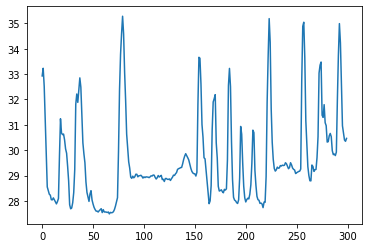

In [34]:
plt.plot(psnr)

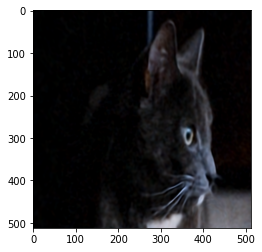

In [35]:
plt.imshow(buff)

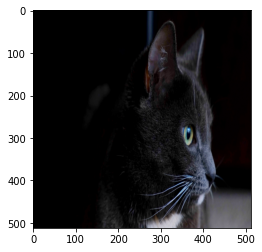

In [36]:
plt.imshow(sub_frames[counter])